In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime, timedelta
from time import mktime

#Helpers
#Cartesian Coordinates relative to earth, conversion implemented from http://faraday.uwyo.edu/~admyers/ASTR5160/handouts/51605.pdf
def convert_cartesian(ra, decl, dist):
  x = dist * np.cos([ra]) * np.cos([decl])
  y = dist * np.sin([ra]) * np.cos([decl])
  z = dist * np.sin([decl])
  return x[0], y[0], z[0]
#Inverse of Cartesian coordinate function, returns cartesian coordinates to ephemeri, RA/DECL/DIST, returns radians or degrees
def convert_ephemeri(x, y , z , radian = True):
  dist = np.sqrt(x**2 + y**2 + z**2)
  ra = np.arctan2(y,x)
  decl = np.arcsin(z/dist)
  #TODO: Finish this
  if radian:
    return ra, decl, dist
  else:
    return math.degrees(ra), math.degrees(decl), dist
#Progress bar helper function
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))
#Data Generator
def generate_ephemeri(body, date_range, earth_loc):
  out = display(progress(0, periods), display_id=True)
  ras = []
  decs = []
  diss = []
  xs = []
  ys = []
  zs = []
  #Generating dates
  loc = EarthLocation.of_site(earth_loc)

  #Generating Ephemeri's
  i = 0
  for t in date_range:
    i += 1
    t = Time(str(t))
    with solar_system_ephemeris.set('jpl'): #Need jplephem library for this
      b = get_body(body, t, loc)
    ra = b.ra.degree
    dec = b.dec.degree
    dis = b.distance.value
    x, y, z = convert_cartesian(b.ra.radian, b.dec.radian, dis)

    ras.append(ra)
    decs.append(dec)
    diss.append(dis)
    xs.append(x)
    ys.append(y)
    zs.append(z)
    #update prog bar    
    out.update(progress(i, periods))
  data = pd.DataFrame({"Time": date_range, "Right Ascension": ras, "Declination": decs, 'Distance': diss, "X": xs, "Y": ys, "Z": zs})
  return data
def find_cycle(data):
  time = []
  max_val = -1* np.inf
  for i in range(len(data)):
    if data['Right Ascension'][i] > max_val:
      max_val = data['Right Ascension'][i]
    elif (max_val - data['Right Ascension'][i]) > 300:
      max_val = data['Right Ascension'][i]
      time.append(data['Time'][i])
  return time

In [ ]:
#Needed for jpl ephemeri data
!pip install jplephem
!pip install astropy


     |████████████████████████████████| 40kB 4.3MB/s 
  Created wheel for jplephem: filename=jplephem-2.15-cp36-none-any.whl size=46021 sha256=55a2f863c33db17a7326e8c75dceed9ebab147d76847c262114396874b7c1218
  Stored in directory: /root/.cache/pip/wheels/01/71/9c/beaa33beb607ef67b62765324a10cd3584e30fbeef8856b7a8
Successfully built jplephem


In [ ]:
# EarthLocation.get_site_names()

In [ ]:
# t = Time("2017-09-25 23:22")
# loc = EarthLocation.of_site('multiple mirror telescope') 
# with solar_system_ephemeris.set('jpl'): #Need jplephem library for this, uncomment pip line above if error
#   jup = get_body('jupiter', t, loc)
# print("Angles of jup: " + jup.to_string())


#### Getting actual angular values as floats:

In [ ]:
#Right ascension
# jup.ra.degree

205.12550987524807

In [ ]:
# Declination
# jup.dec.degree

-9.307326856956667

In [ ]:
#Distance
jup.distance.value

949428221.2029486

In [ ]:
cartesian  = convert_cartesian(jup.ra.radian, jup.dec.radian, jup.distance.value)
print(cartesian)
spherical = convert_ephemeri(cartesian[0], cartesian[1], cartesian[2], False)
print(spherical)

(-848276665.9426457, -397822476.38054323, -153551042.06835082)
(-154.87449012475193, -9.307326856956667, 949428221.2029487)


# Testing/Exploring Generating Data through a certain time period:

In [ ]:
periods = 500
times = pd.date_range('2012-10-01', periods=periods, freq = '2D')
data = generate_ephemeri('jupiter',times, 'multiple mirror telescope')

Some nice results that we can graph! Note the epicycles that are clearly occurring

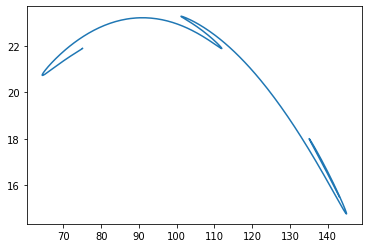

In [ ]:
plt.plot(data['Right Ascension'], data['Declination'])
plt.show()

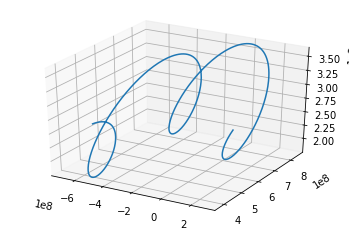

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(data['X'], data['Y'], data['Z'])

These data were at the same time every day, lets take a look at some hourly iterations and see if it shows a similar pattern. We want to make sure our coordinate system is global and does not change based on Earth's rotation during the day.

In [ ]:
periods = 5000
times = pd.date_range('2010-10-01', periods=periods, freq='1D')
data = generate_ephemeri('jupiter',times, 'multiple mirror telescope')

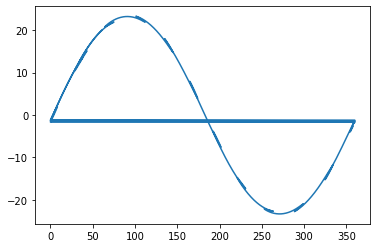

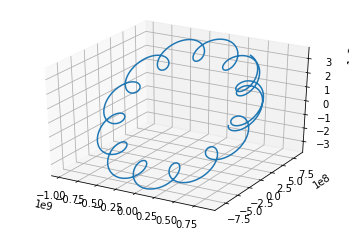

In [ ]:
plt.plot(data['Right Ascension'], data['Declination'])
plt.show()
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(data['X'], data['Y'], data['Z'])
fig.show()

#### Moon orbit: Elliptical, no noticeable epicycles like for the other planets

In [ ]:
periods = 500
times = pd.date_range('2012-10-01', periods=periods, freq='3H')
times
# data = generate_ephemeri('moon',times, 'multiple mirror telescope')

DatetimeIndex(['2012-10-01 00:00:00', '2012-10-01 03:00:00',
               '2012-10-01 06:00:00', '2012-10-01 09:00:00',
               '2012-10-01 12:00:00', '2012-10-01 15:00:00',
               '2012-10-01 18:00:00', '2012-10-01 21:00:00',
               '2012-10-02 00:00:00', '2012-10-02 03:00:00',
               ...
               '2012-12-01 06:00:00', '2012-12-01 09:00:00',
               '2012-12-01 12:00:00', '2012-12-01 15:00:00',
               '2012-12-01 18:00:00', '2012-12-01 21:00:00',
               '2012-12-02 00:00:00', '2012-12-02 03:00:00',
               '2012-12-02 06:00:00', '2012-12-02 09:00:00'],
              dtype='datetime64[ns]', length=500, freq='3H')

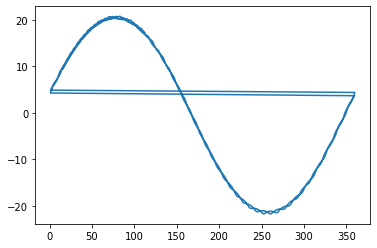

In [ ]:
plt.plot(data['Right Ascension'], data['Declination'])
plt.show()

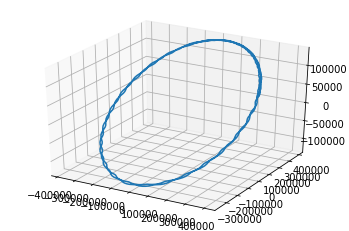

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(data['X'], data['Y'], data['Z'])

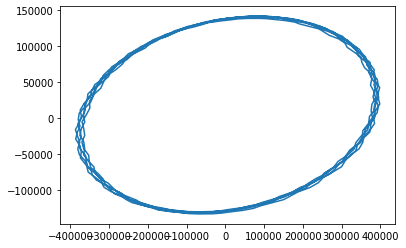

In [ ]:
plt.plot(data['X'], data['Y'])

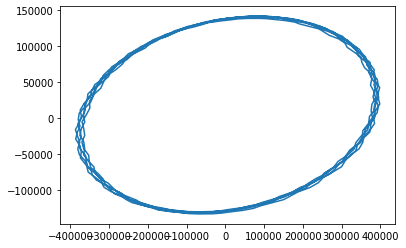

In [ ]:
plt.plot(data['X'], data['Z'])

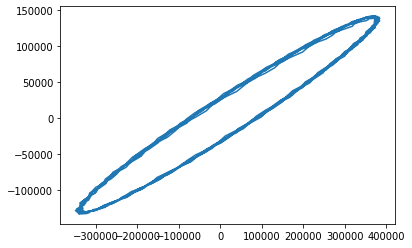

In [ ]:
plt.plot(data['Y'], data['Z'])

Mercury:

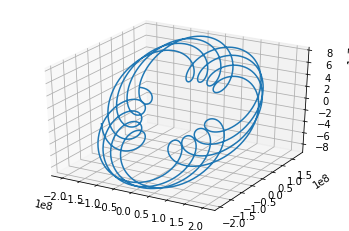

In [ ]:
periods = 5000
times = pd.date_range('2012-10-01', periods=periods, freq='7H')
data = generate_ephemeri('mercury',times, 'multiple mirror telescope')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(data['X'], data['Y'], data['Z'])

In [ ]:
cycles = find_cycle(data)
zeros = np.zeros(len(cycles))
plt.plot(data['Time'], data['Right Ascension'])
plt.plot(data['Time'], data['Declination'])
plt.scatter(cycles, zeros)
plt.legend(['Right Ascension', 'Declination'])

In [ ]:
prev = cycles[0]
for i in cycles:
  next = i
  if next != prev:
    print(next - prev)
    prev = i

Individual Axes:


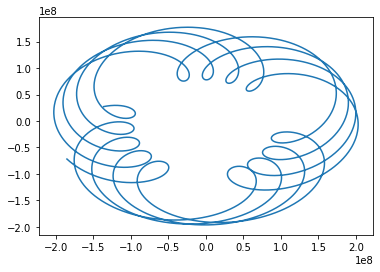

In [ ]:
plt.plot(data['X'], data['Y'])

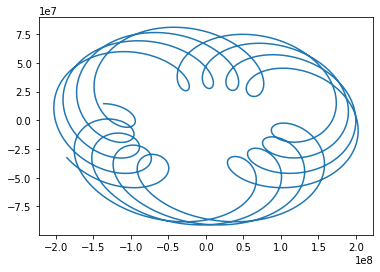

In [ ]:
plt.plot(data['X'], data['Z'])

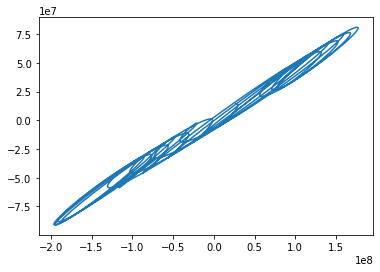

In [ ]:
plt.plot(data['Y'], data['Z'])

### Learning 1D function t ---> [x, y, z]


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime, timedelta
from time import mktime


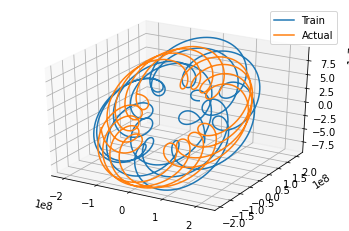

In [ ]:
T = data.copy()


# t = datetime.now()
unix_secs = data["Time"].apply(lambda t: mktime(t.timetuple()))
T["Time"] = unix_secs
# T.head()

T_train = np.array(T["Time"])[:,np.newaxis]
target = np.array(T[["X", "Y", "Z"]])
poly = PolynomialFeatures(7)
poly = poly.fit_transform(T_train)
# poly.shape
w = np.linalg.inv(poly.T@poly)@poly.T@target

pred_mat = poly@w - target
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(pred_mat[:, 0], pred_mat[:, 1], pred_mat[:, 2])
ax.plot(data['X'], data['Y'], data['Z'])
ax.legend(['Train','Actual'])
fig.show()
# T_train

# Generating Data for CSV

We want each planetary body to have enough data for a train/validation split as well as some test data on which to demonstrate our final models performance after tuning. We must keep orbits of planets in mind, different planetary bodies have different cycle times which means 300 days worth of data for mercury will give us more information about its orbit then 300 days worth of data for jupiter as we can see in the above data exploration section. With that in mind, we will need to generate more data for these planets with longer orbital cycles so we can capture the pattern of orbit.

Additionally, there is a function which one of the Project S Early group, Team VNS(https://github.com/ArnaudFickinger/astronomical_dataset_generator), have created which we can use to add random noise to our generated data so as to better mimic the data that Ptolemy had. This random noise will force for us to explore some regularization options to make more robust predictions with this included noise and determine the performance of our model had we lived in Ptolemy's time and used his observations.

Note: Standardized start times to be 1985-01-01  To allow for stable data generation for all planetary bodies.

In [ ]:
from google.colab import  drive
#TEAM VNS HELPERS

#add noise to data, data must be in [x,y,z] format or you know what you are doing
#possible type of noise are gaussian/uniform random noise
def addnoise(data,mu,sigma,typ="gaussian"):
    print("adding ",typ," noise to data......")
    print("mu=",mu," and sigma=",sigma)
    ldata=np.copy(data)
    shape=np.shape(ldata)
    ldata=ldata.flatten()
    size=len(ldata)
    if typ=="gaussian":
        ldata+=np.random.normal(mu,sigma,size=size)
    elif typ=="uniform":        
        ldata+=sigma*(np.random.rand(size)-0.5+mu)
    else:
        print("invalid type of noise!")
        print("available types of noise are gaussian or uniform.")
        exit(1)
    return ldata.reshape(shape)
#randomly delete percentage of data assigned by percent
#you may want to do this to sparsify the data due random conditions like weathers, people in charge of observing ask for a day off or so.
def sparsify(data,percent):
    n=len(data)
    ndrawn=int(n*(1-percent))
    print("sparsify ",n,"data into ",n-ndrawn," data...")
    dellist=random.sample(range(n),ndrawn)
    return np.delete(data,dellist,axis=0)

Mounted at /drive


### Sun

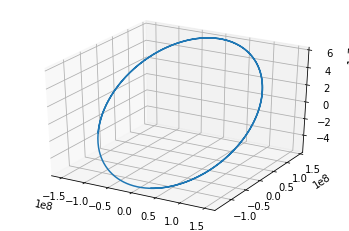

In [ ]:
periods = 10500
times = pd.date_range('2018-01-01', periods=periods, freq='90T')
data = generate_ephemeri('sun',times, 'multiple mirror telescope')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(data['X'], data['Y'], data['Z'])

In [ ]:
data.to_csv('../../Data/Sun_phase2.csv')
print('Data saved to ../../Data/Sun_phase2.csv')

Data saved to drive/My Drive/PROJ S/Train_Test_data/Sun_phase2.csv


### Moon

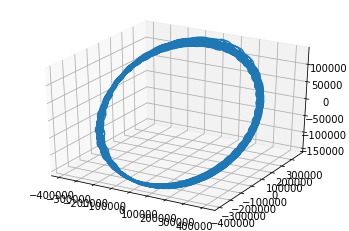

In [ ]:
periods = 10500
times = pd.date_range('2018-01-01', periods=periods, freq='90T')
data = generate_ephemeri('moon',times, 'multiple mirror telescope')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(data['X'], data['Y'], data['Z'])

In [ ]:
data.to_csv('../../Data/Moon_phase2.csv')
print('Data saved to ../../Data/Moon_phase2.csv')

Data saved to drive/My Drive/PROJ S/Train_Test_data/Moon_phase2.csv


In [ ]:
import ipyparallel as ipp
rc = ipp.Client()

ModuleNotFoundError: No module named 'ipyparallel'

### Mercury

2015-11-03


c:\users\rodri\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\users\rodri\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\users\rodri\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


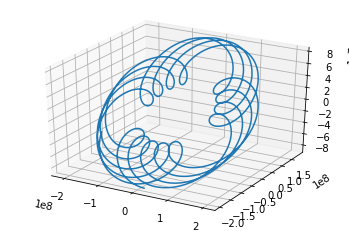

In [ ]:
periods = 10500

# ~1 yr
orbit_time = 4*380
per_day = periods//380

end_str = '2020-1-1'
end = datetime.strptime(end_str, '%Y-%m-%d')
# goback = 
DD = timedelta(days=orbit_time)
start = end - DD
start_str = start.strftime("%Y-%m-%d")

print(start_str)
times = pd.date_range(start_str, end_str, periods=periods)
merc = generate_ephemeri('mercury',times, 'multiple mirror telescope')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(merc['X'], merc['Y'], merc['Z'])

In [ ]:
merc.to_csv('../../Data/Mercury4x.csv')
# print('Data saved to ../../Data/Mercury.csv')

### Venus

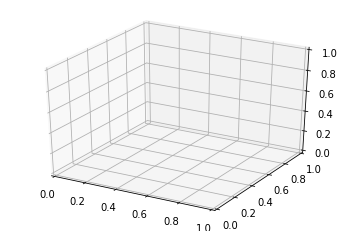

In [ ]:
periods = 10500

orbit_time = 4*365*8.1
# per_day = periods//

end_str = '2020-1-1'
end = datetime.strptime(end_str, '%Y-%m-%d')
# goback = 
DD = timedelta(days=orbit_time)
start = end - DD
start_str = start.strftime("%Y-%m-%d")

times = pd.date_range(start_str, end_str, periods=periods)
veen = generate_ephemeri('venus',times, 'multiple mirror telescope')
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.plot(['X'], data['Y'], data['Z'])

In [ ]:
veen.to_csv('../../Data/')
print('Data saved to ../../Data/Venus.csv')

Data saved to /drive/My Drive/EECS189/PROJ S/Normal Data/Venus.csv


### Mars

1990-01-08


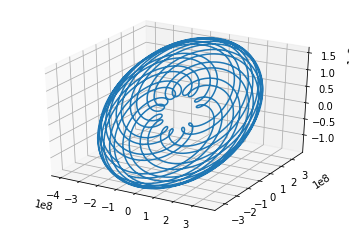

In [ ]:
periods = 10500

orbit_time = 2*15*365
# per_day = periods//380

end_str = '2020-1-1'
end = datetime.strptime(end_str, '%Y-%m-%d')
# goback = 
DD = timedelta(days=orbit_time)
start = end - DD
start_str = start.strftime("%Y-%m-%d")

print(start_str)
times = pd.date_range(start_str, end_str, periods=periods)

# data = generate_ephemeri('mars',times, 'multiple mirror telescope')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(data['X'], data['Y'], data['Z'])

In [ ]:
data.to_csv('../../Data/Mars2x.csv')
print('Data saved to ../../Data/Mars.csv')

Data saved to /drive/My Drive/EECS189/PROJ S/Normal Data/Mars.csv


### Jupiter

1971-08-20


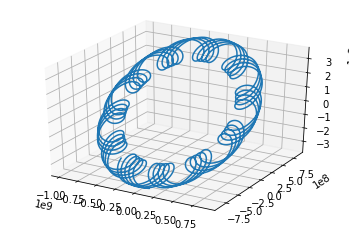

In [ ]:
#We see 5000 periods is sufficient to cover a cycle
periods = 10500

# periods = 10500

# ~1 yr
orbit_time = 4*12.1*365

# periods = 10500

# orbit_time = 4*10585

end_str = '2020-1-1'
end = datetime.strptime(end_str, '%Y-%m-%d')
DD = timedelta(days=orbit_time)
start = end - DD
start_str = start.strftime("%Y-%m-%d")

print(start_str)
times = pd.date_range(start_str, end_str, periods=periods)
jup = generate_ephemeri('jupiter',times, 'multiple mirror telescope')
jup.to_csv('Juipter4x.csv')

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(jup['X'], jup['Y'], jup['Z'])

In [ ]:
data.to_csv('../../Data/Jupiter2x.csv')
print('Data saved to ../../Data/Jupiter.csv')

Data saved to /drive/My Drive/EECS189/PROJ S/Normal Data/Jupiter.csv


### Saturn

1779-01-24


c:\users\rodri\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\users\rodri\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\users\rodri\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


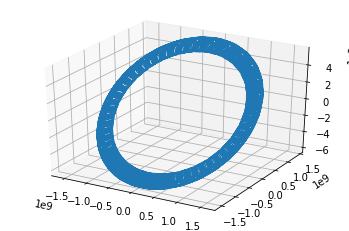

In [ ]:
periods = 10500

# orbit_time = 8*10585
orbit_time = 8*11000

end_str = '2020-1-1'
end = datetime.strptime(end_str, '%Y-%m-%d')
DD = timedelta(days=orbit_time)
start = end - DD
start_str = start.strftime("%Y-%m-%d")

print(start_str)
times = pd.date_range(start_str, end_str, periods=periods)
sat = generate_ephemeri('saturn',times, 'multiple mirror telescope')
sat.to_csv('Saturn4x.csv')

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(sat['X'], sat['Y'], sat['Z'])

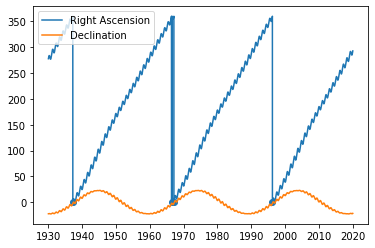

In [ ]:
cycles = find_cycle(data)
zeros = np.zeros(len(cycles))
plt.plot(data['Time'], data['Right Ascension'])
plt.plot(data['Time'], data['Declination'])
plt.scatter(cycles, zeros)
plt.legend(['Right Ascension', 'Declination'])

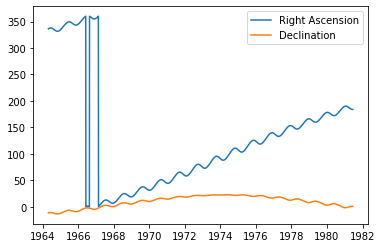

In [ ]:
cycles = find_cycle(data)
zeros = np.zeros(len(cycles))
plt.plot(data['Time'][4000:6000], data['Right Ascension'][4000:6000])
plt.plot(data['Time'][4000:6000], data['Declination'][4000:6000])
plt.scatter(cycles[4000:6000], zeros[4000:6000])
plt.legend(['Right Ascension', 'Declination'])

In [ ]:
data.to_csv('../../Data/Saturn2x.csv')
print('Data saved to ../../Data/Saturn2x.csv')

Data saved to /drive/My Drive/EECS189/PROJ S/Train_Test_data/Saturn2x.csv


### Uranus

1684-03-22


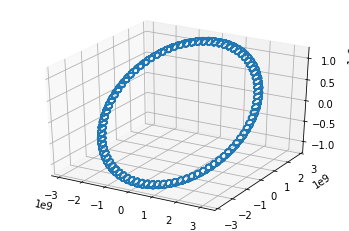

In [ ]:
periods = 10500

orbit_time = 4*30660

end_str = '2020-1-1'
end = datetime.strptime(end_str, '%Y-%m-%d')
DD = timedelta(days=orbit_time)
start = end - DD
start_str = start.strftime("%Y-%m-%d")

print(start_str)
times = pd.date_range(start_str, end_str, periods=periods)
uran = generate_ephemeri('uranus',times, 'multiple mirror telescope')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(uran['X'], uran['Y'], uran['Z'])

In [ ]:
uran.to_csv('../../Data/Uranus4x_new.csv')
print('Data saved to ../../Data/Uranus2x.csv')

Data saved to /drive/My Drive/EECS189/PROJ S/Train_Test_data/Uranus2x.csv


### Neptune

In [ ]:
pd.Period(value = start.strftime("%Y-%m-%d"))

Period('1364-06-08', 'D')

In [ ]:
periods = 10500

orbit_time = 4*59860

end_str = '2020-1-1'
end = datetime.strptime(end_str, '%Y-%m-%d')
DD = timedelta(days=orbit_time)
start = end - DD
start_str = pd.Period(start.strftime("%Y-%m-%d"))

print(start_str)
times = pd.date_range(pd.Period(start_str).to_timestamp(), end_str.to_timestamp(), periods=periods)
nep = generate_ephemeri('neptune',times, 'multiple mirror telescope')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(nep['X'], nep['Y'], nep['Z'])

1364-06-08


OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1364-06-08 00:00:00

In [ ]:
nep.to_csv('../../Data/Neptune4x.csv')
print('Data saved to ../../Data/Neptune2x.csv')

Data saved to /drive/My Drive/EECS189/PROJ S/Train_Test_data/Neptune2x.csv


### Pluto

1520-05-02


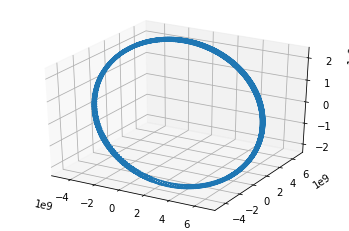

In [ ]:
periods = 10500

orbit_time = 2*91250

end_str = '2020-1-1'
end = datetime.strptime(end_str, '%Y-%m-%d')
DD = timedelta(days=orbit_time)
start = end - DD
start_str = start.strftime("%Y-%m-%d")

print(start_str)
times = pd.period_range(end = end_str, periods = periods, freq = '16D')
data = generate_ephemeri('pluto',times, 'multiple mirror telescope')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(data['X'], data['Y'], data['Z'])

In [ ]:
data.to_csv('../../Data/Pluto2x.csv')
print('Data saved to ../../Data/Pluto2x.csv')

Data saved to /drive/My Drive/EECS189/PROJ S/Train_Test_data/Pluto2x.csv
